In [1]:
import os
import pickle
import re
import shutil
import time
from itertools import chain
from pathlib import Path

from cytoolz import groupby, merge, keyfilter
from cytoolz.curried import get, get_in
from killscreen import subutils, shortcuts as ks
from killscreen.aws import ec2
import pyarrow as pa
import pyarrow.csv
from gPhoton.pretty import make_monitors
from more_itertools import distribute
from pyarrow import parquet

os.chdir(globals()['_dh'][0].parent)

from subset.utilz.mount_s3 import mount_bucket
from subset.science.handlers import (
    filter_ps1_catalog, sample_ps1_catalog, get_corresponding_images, bulk_skycut
)
from subset.science.ps1_utils import (
    ps1_stack_path, request_ps1_cutout, PS1_CUT_CONSTANTS
)
from subset.utilz.generic import parse_topline, sample_table

key = "/home/ubuntu/.ssh/galex_swarm.pem"
uname = "ubuntu"
DUMP_PATH = '/home/ubuntu/.slice_test/'
os.makedirs(DUMP_PATH, exist_ok=True)
S3_ROOT = "/mnt/s3"
BUCKET="nishapur"
# mount bucket to fetch metadata
mount_bucket(backend="goofys", mount_path=S3_ROOT, bucket=BUCKET)

In [2]:
# initialize a killscreen Cluster
descriptions = ec2.ls_instances(name='fornax_slice')
# ...either from already-running EC2 instances...
if len(descriptions) == 0:
    cluster = ec2.Cluster.launch(
        count=4,
        template="fornax-slice", 
        key=key, 
        uname=uname, 
        use_private_ip=True
    )
# ...or from a new fleet request.
else:
    cluster = ec2.Cluster.from_descriptions(
        descriptions, key=key, uname=uname, use_private_ip=True
    )
    cluster.start()
    [instance.wait_until_running() for instance in cluster.instances]
    cluster.add_public_keys()
    print("\n".join([str(i) for i in cluster.instances]))

fornax_slice (i-0e1e77144a3e89005): m6i.2xlarge in us-east-1b at 172.31.86.117
fornax_slice (i-02a9f21876a28bf24): m6i.2xlarge in us-east-1b at 172.31.94.18
fornax_slice (i-0e0c13cc18ebf5807): m6i.2xlarge in us-east-1b at 172.31.90.252
fornax_slice (i-0476737f38b4f4312): m6i.2xlarge in us-east-1b at 172.31.95.151


In [3]:
# freshen these instances
def git_update(*repo_names):
    return ks.chain(
        [f"cd {repo}; git clean -d -fx; git pull & cd ~" for repo in repo_names], "and"
    )
update = git_update("fornax-s3-subsets", "killscreen", "gphoton_working")
updaters = cluster.command(update, _bg=True, _viewer=True)
# what script / interpreter are we actually using on the remote instances
env = cluster.instances[0].conda_env("fornax_section")
python = f"{env}/bin/python"
endpoint = "/home/ubuntu/fornax-s3-subsets/subset/ps1_cutout_endpoint.py"

In [4]:
# set up metadata objects in order to pick targets for slicing

# catalog of PS1 extragalactic extended objects, including explicit
# assignments to PS1 stack image projection / sky cells and GALEX 
# eclipse numbers (not used here)
CATALOG_FN = "ps1_eg_eclipses_subset_best_gz_coregistered.parquet"
if not Path(CATALOG_FN).exists():
    shutil.copy(Path(S3_ROOT, "ps1/metadata", CATALOG_FN), Path(CATALOG_FN))
catalog = parquet.read_table(CATALOG_FN).to_pandas()
# cutouts in dimensions: ra, dec in degrees. treated as side lengths of a rectangle.
CUT_SHAPE = (60 / 3600, 60 / 3600)
# restrict to sources bright in both g and z? set to 'None' for no cutoff.
MAG_CUTOFF = 20
# restrict to only sources flagged as extended / not extended?
# "extended", "point", or None for no restriction
EXTENSION_TYPE = "extended"
# restrict to only sources with a valid stack detection? (probably a good idea)
STACK_ONLY = True
# which PS1 bands are we considering? (only g and z are currently staged, but you can stage more.)
PS1_BANDS = ("g", "z")

In [5]:
# various settings for the test
# how many objects shall we collect slices for? (785510 are available in this test set)
TARGET_COUNT = 2000
# optional parameter -- restrict the total number of PS1 source cells to test the 
# performance effects of denser sampling.
# (1000 total PS1 cells are available in this test set).
# note that the total number of images accessed is number of cells * number of bands.
MAX_CELL_COUNT = 500
CUT_SHAPE = (60 / 3600, 60 / 3600)
candidate_sources = filter_ps1_catalog(catalog, MAG_CUTOFF, EXTENSION_TYPE, STACK_ONLY)
# randomly-selected subset of those sources w/adequate metadata for cutout definition
targets = sample_ps1_catalog(candidate_sources, TARGET_COUNT, MAX_CELL_COUNT)
# add requested cut shape instructions to these target definitions
targets = [t | {'ra_x': CUT_SHAPE[0], 'dec_x': CUT_SHAPE[1]} for t in targets]
# prune them so they're easy to send over ssh
keys_of_interest = ('proj_cell', 'sky_cell', 'ra', 'dec', 'ra_x', 'dec_x')
def keep_keys(records, keys):
    return list(map(lambda d: keyfilter(lambda k: k in keys, d), records))

targets = keep_keys(targets, keys_of_interest)
# split these into chunks of work, making sure that all targets within
# a single cell / image are assigned to the same instance --
target_groups = groupby(get(['proj_cell', 'sky_cell']), targets)
# this is a simple heuristic to distribute work evenly, given the above constraint:
groups = sorted(target_groups.values(), key=lambda v: 1 / len(v))
work_chunks = [
    tuple(chain.from_iterable(chunk)) 
    for chunk in distribute(len(cluster.instances), groups)
]

In [6]:
# log summary function
def parse_topline(log):
    """parse top line of output log from skybox-slicing examples."""
    total = next(reversed(log.values()))
    summary, duration, volume = total.split(",")
    cut_count = int(re.search(r"\d+", summary).group())
    seconds = float(re.search(r"\d+\.?\d+", duration).group())
    megabytes = float(re.search(r"\d+\.?\d+", volume).group())
    rate = cut_count / seconds
    weight = megabytes / cut_count
    return round(rate, 2), round(weight, 2)

# simple process join function
def wait_on(processes, polling_delay=0.1):
    while any([p.is_alive() for p in processes]):
        time.sleep(polling_delay)

In [7]:
# then run the commands!

# when a remote process is done, grab the files from that instance
# this could be done more concurrently, but synchronizing is a pain.
# maybe scp from remotes? ideally inside the dump loop.
getters = []
def grab_when_done(process, *_):
    print(f"{process.host.ip} done; getting files")
    getter = process.host.get(f"{DUMP_PATH}*", DUMP_PATH, _bg=True)
    getters.append(getter)
        
# delete everything local so as to avoid confusion
subutils.run(f"rm {DUMP_PATH}/* &")

# set up some basic benchmarking...
stat, note = make_monitors(silent=True, round_to=2)
# ...and initiate the remote processes
remote_processes = []
for chunk, instance in zip(work_chunks, cluster.instances):
    command = f"{python} {endpoint} '{chunk}'"
    viewer = instance.command(
        command, _bg=True, _viewer=True, _done=grab_when_done
    )
    remote_processes.append(viewer)
wait_on(remote_processes)
note(f"remote processes completed,{stat()}", True)
wait_on(getters)
note(f"cleaned up files from remotes,{stat()}", True)

retrieved_dumps = os.listdir(DUMP_PATH)

cutfiles = tuple(filter(lambda f: f.endswith("pkl"), retrieved_dumps))
# n_targets=
note(f"got {len(targets) * 2} cuts,{stat(total=True)}", True)
log = note(None, eject=True)
rate, weight = parse_topline(log)
print(f"{rate} cutouts/s, {weight} MB / cutout (local only)")

# clean up cached arrays on remotes
deletions = cluster.command(f"rm {DUMP_PATH}/* &", _bg=True)

172.31.86.117 done; getting files
172.31.94.18 done; getting files
172.31.90.252 done; getting files
172.31.95.151 done; getting files
remote processes completed,16.73 s,474.53 MB
cleaned up files from remotes,0.91 s,377.07 MB
got 4000 cuts,17.65 total s,851.61 total MB
226.63 cutouts/s, 0.21 MB / cutout (local only)


In [8]:
# should you like: examine logs from remotes...
import pandas as pd
logs = []
for logfile in filter(lambda f: f.endswith("csv"), retrieved_dumps):
    remote_log = pd.read_csv(Path(DUMP_PATH, logfile))
    remote_log["host"] = re.search(
        r"(?<=ip_)(\d+_){4}", logfile
    ).group(0)[:-1]
    logs.append(remote_log)
logs = pd.concat(logs).drop(columns='3')
logs.columns = ["timestamp", "event", "duration", "volume", "host"]
logs.sort_values(by=["host", "timestamp"])

,timestamp,event,duration,volume,host
0,2022-09-28T19:55:07.035471,initialized 40 images,0.6684679985046387 s,3.13212 MB,172_31_86_117
1,2022-09-28T19:55:08.218321,made 172 cutouts,1.1828186511993408 s,137.066006 MB,172_31_86_117
2,2022-09-28T19:55:08.793691,initialized 40 images,0.575333833694458 s,2.50613 MB,172_31_86_117
3,2022-09-28T19:55:09.959697,made 166 cutouts,1.1659691333770752 s,184.902155 MB,172_31_86_117
4,2022-09-28T19:55:10.626336,initialized 40 images,0.6666111946105957 s,3.780675 MB,172_31_86_117
5,2022-09-28T19:55:11.894303,made 160 cutouts,1.2679309844970703 s,227.487907 MB,172_31_86_117
6,2022-09-28T19:55:12.617516,initialized 40 images,0.7231826782226562 s,5.919576 MB,172_31_86_117
7,2022-09-28T19:55:14.295578,made 200 cutouts,1.6780312061309814 s,316.963556 MB,172_31_86_117
8,2022-09-28T19:55:14.991742,initialized 40 images,0.6961333751678467 s,5.306512 MB,172_31_86_117
9,2022-09-28T19:55:16.152039,made 168 cutouts,1.1602652072906494 s,165.828716 MB,172_31_86_117


In [9]:
# ...or your winnings
cuts = []
for file in cutfiles:
    with open(Path(DUMP_PATH, file), "rb") as stream:
        cuts.append(pickle.load(stream))
cuts = list(chain.from_iterable(cuts))
arrays = tuple(map(get_in(['arrays', 0]), cuts))

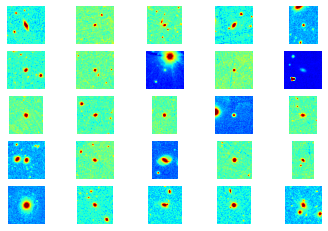

In [10]:
from random import choice
import matplotlib.pyplot as plt
import numpy as np

fig, grid = plt.subplot_mosaic(np.arange(25).reshape(5, 5))
plt.close()
for ax in grid.values():
    ax.set_axis_off()

for ix in grid.keys():
    array = arrays[choice(range(len(arrays)))]
    clipped = np.clip(array, *np.percentile(array, (1, 99)))
    grid[ix].imshow(clipped, cmap='jet')
    
fig

In [ ]:
# destroy the cluster if you are done with it
cluster.terminate()